In [4]:
import spacy
import requests
import pandas as pd
from spacy.lang.en.examples import sentences
from spacy import displacy
import matplotlib.pyplot as plt

In [5]:
# Load the spacy model
nlp = spacy.load('en_core_web_md')

In [6]:
text = "I work as a software engineer for Goldman Sachs in New York City."
displacy.render(nlp(text), style='ent', jupyter=True)

## 1) Anaylzing Positive vs. Negative Features

In [7]:
# read xlsx file as a df
df = pd.read_excel('../data/BookingDotCom_HotelReviews.xlsx')
df.head()

Hotel_Name                                      Hotel_Address  \
0  Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1  Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2  Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3  Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4  Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Review_Count  Non_Review_Scoring_Count  Average_Hotel_Score Review_Date  \
0          1403                       194                  7.7  2017-08-03   
1          1403                       194                  7.7  2017-08-03   
2          1403                       194                  7.7  2017-07-31   
3          1403                       194                  7.7  2017-07-31   
4          1403                       194                  7.7  2017-07-24   

  Reviewer_Nationality                                  Positive_Comments  \
0              Russia    Only the park outside of the hotel was beauti...   
1             Ireland    No real complaints the hotel was great great ...   
2           Australia    Location was good and staff were ok It is cut...   
3      United Kingdom    Great location in nice surroundings the bar a...   
4         New Zealand     Amazing location and building Romantic setting    

                                   Negative_Comments  Total_Reviewer_Reviews  \
0   I am so angry that i made this post available...                       7   
1                                        No Negative                       7   
2   Rooms are nice but for elderly a bit difficul...                       9   
3   My room was dirty and I was afraid to walk ba...                       1   
4   You When I booked with your company on line y...                       3   

   Reviewer_Score                                               Tags  
0             2.9  [' Leisure trip ', ' Couple ', ' Duplex Double...  
1             7.5  [' Leisure trip ', ' Couple ', ' Duplex Double...  
2             7.1  [' Leisure trip ', ' Family with young childre...  
3             3.8  [' Leisure trip ', ' Solo traveler ', ' Duplex...  
4             6.7  [' Leisure trip ', ' Couple ', ' Suite ', ' St...

In [8]:
# normalise the columns, make everything lowercase
df.columns = df.columns.str.lower()
df.columns

Index(['hotel_name', 'hotel_address', 'review_count',
       'non_review_scoring_count', 'average_hotel_score', 'review_date',
       'reviewer_nationality', 'positive_comments', 'negative_comments',
       'total_reviewer_reviews', 'reviewer_score', 'tags'],
      dtype='object')

In [9]:
# make positive_comments column lowercase, same for negative_comments
df['positive_comments'] = df['positive_comments'].str.lower()
df['negative_comments'] = df['negative_comments'].str.lower()
df['tags'] = df['tags'].str.lower()

In [10]:
# make 2 new df's, one for positive reviews and one for negative reviews
df_pos = df[df['reviewer_score'] > 7]
df_neg = df[df['reviewer_score'] < 4]
df_pos.head()

hotel_name                                      hotel_address  \
1   Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
7   Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
9   Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
10  Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

    review_count  non_review_scoring_count  average_hotel_score review_date  \
1           1403                       194                  7.7  2017-08-03   
2           1403                       194                  7.7  2017-07-31   
7           1403                       194                  7.7  2017-07-17   
9           1403                       194                  7.7  2017-07-08   
10          1403                       194                  7.7  2017-07-07   

   reviewer_nationality                                  positive_comments  \
1              Ireland    no real complaints the hotel was great great ...   
2            Australia    location was good and staff were ok it is cut...   
7       United Kingdom    good location set in a lovely park friendly s...   
9               Norway    the room was big enough and the bed is good t...   
10      United Kingdom    rooms were stunningly decorated and really sp...   

                                    negative_comments  total_reviewer_reviews  \
1                                         no negative                       7   
2    rooms are nice but for elderly a bit difficul...                       9   
7    apart from the price for the brekfast everyth...                       1   
9    the aircondition makes so much noise and its ...                       1   
10                                 nothing all great                        2   

    reviewer_score                                               tags  
1              7.5  [' leisure trip ', ' couple ', ' duplex double...  
2              7.1  [' leisure trip ', ' family with young childre...  
7             10.0  [' leisure trip ', ' couple ', ' duplex double...  
9              7.9  [' leisure trip ', ' couple ', ' large king ro...  
10            10.0  [' leisure trip ', ' group ', ' duplex double ...

In [11]:
print(df_pos.shape, df_neg.shape)

(428476, 12) (10728, 12)


In [12]:
# normalise the tags column by making everything lowercase, the column has a list of strings
df['tags'] = df['tags'].str.lower()
df['tags'].head()

0    [' leisure trip ', ' couple ', ' duplex double...
1    [' leisure trip ', ' couple ', ' duplex double...
2    [' leisure trip ', ' family with young childre...
3    [' leisure trip ', ' solo traveler ', ' duplex...
4    [' leisure trip ', ' couple ', ' suite ', ' st...
Name: tags, dtype: object

In [13]:
# Sample 100 reviews from each df
df_pos_sample = df_pos.sample(n=2500)
df_neg_sample = df_neg.sample(n=2500)

In [14]:
positive_features = dict()
# iterate through the positive reviews and extract the features from column positive_comments
for index, row in df_pos_sample.iterrows():
    positive = row['positive_comments']
    doc = nlp(positive)
    # if pos is noun, or adjective add it to the dictionary
    for token in doc:
        # if token.pos_ == 'NOUN' or token.pos_ == 'ADJ':
        if token.pos_ == 'ADJ':
            if token.text in positive_features:
                positive_features[token.text] += 1
            else:
                positive_features[token.text] = 1

# sort the dictionary by the values
positive_sorted = sorted(positive_features.items(), key=lambda x: x[1], reverse=True)
positive_sorted

[('great', 551),
 ('good', 532),
 ('friendly', 453),
 ('helpful', 399),
 ('nice', 359),
 ('clean', 352),
 ('excellent', 349),
 ('comfortable', 342),
 ('lovely', 222),
 ('perfect', 150),
 ('positive', 133),
 ('amazing', 129),
 ('comfy', 114),
 ('fantastic', 110),
 ('quiet', 104),
 ('modern', 94),
 ('spacious', 88),
 ('close', 87),
 ('free', 84),
 ('easy', 75),
 ('beautiful', 72),
 ('best', 71),
 ('central', 69),
 ('wonderful', 61),
 ('big', 60),
 ('small', 58),
 ('large', 47),
 ('convenient', 46),
 ('polite', 42),
 ('pleasant', 39),
 ('next', 38),
 ('little', 35),
 ('professional', 33),
 ('efficient', 33),
 ('few', 32),
 ('short', 31),
 ('many', 31),
 ('extra', 31),
 ('attentive', 29),
 ('superb', 29),
 ('new', 28),
 ('other', 28),
 ('warm', 26),
 ('special', 26),
 ('more', 26),
 ('fabulous', 25),
 ('front', 25),
 ('brilliant', 25),
 ('high', 24),
 ('top', 24),
 ('main', 23),
 ('delicious', 22),
 ('complimentary', 21),
 ('hot', 21),
 ('much', 21),
 ('cool', 21),
 ('ideal', 20),
 ('huge'

In [15]:
negative_features = dict()
# iterate through the positive reviews and extract the features from column positive_comments
for index, row in df_neg_sample.iterrows():
    negative = row['negative_comments']
    doc = nlp(negative)
    # if pos is noun, or adjective add it to the dictionary
    for token in doc:
        # if token.pos_ == 'NOUN' or token.pos_ == 'ADJ':
        if token.pos_ == 'ADJ':
            if token.text in negative_features:
                negative_features[token.text] += 1
            else:
                negative_features[token.text] = 1

# sort the dictionary by the values
negative_sorted = sorted(negative_features.items(),
                         key=lambda x: x[1], reverse=True)
negative_sorted


[('small', 402),
 ('bad', 325),
 ('dirty', 297),
 ('poor', 275),
 ('rude', 235),
 ('old', 219),
 ('other', 150),
 ('good', 144),
 ('noisy', 141),
 ('clean', 132),
 ('double', 131),
 ('first', 126),
 ('worst', 122),
 ('terrible', 120),
 ('more', 119),
 ('hot', 107),
 ('tiny', 106),
 ('negative', 100),
 ('cold', 100),
 ('horrible', 97),
 ('better', 95),
 ('uncomfortable', 94),
 ('same', 93),
 ('awful', 91),
 ('next', 91),
 ('expensive', 81),
 ('extra', 80),
 ('many', 73),
 ('friendly', 72),
 ('available', 71),
 ('full', 68),
 ('worth', 66),
 ('front', 64),
 ('single', 61),
 ('second', 58),
 ('big', 58),
 ('new', 57),
 ('nice', 56),
 ('whole', 55),
 ('helpful', 54),
 ('disappointed', 52),
 ('different', 50),
 ('unfriendly', 50),
 ('tired', 50),
 ('wrong', 49),
 ('unhelpful', 49),
 ('free', 47),
 ('high', 45),
 ('loud', 45),
 ('only', 45),
 ('ready', 45),
 ('long', 45),
 ('much', 43),
 ('twin', 42),
 ('enough', 42),
 ('basic', 39),
 ('dark', 38),
 ('slow', 38),
 ('such', 37),
 ('disgusting

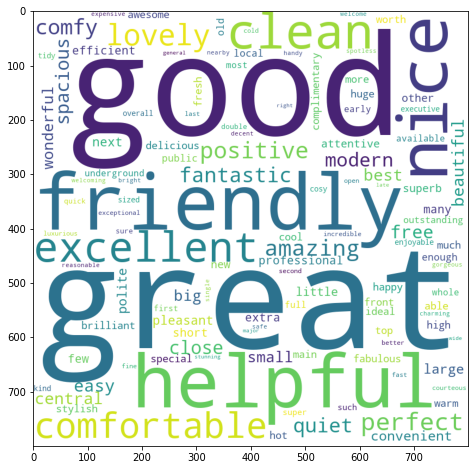

In [16]:
# make word cloud with positive features and negative features
from wordcloud import WordCloud

# make a word cloud for positive features
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(positive_features)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

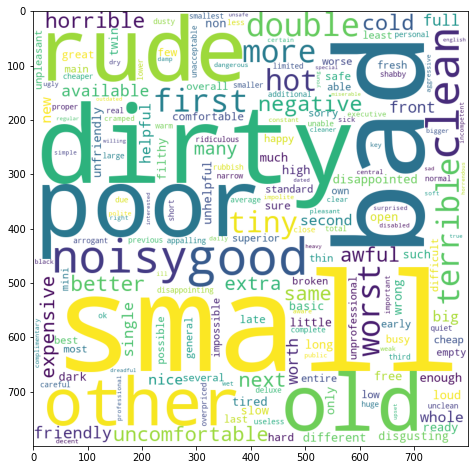

In [17]:
# make a word cloud for positive features
wordcloud = WordCloud(width=800, height=800, background_color='white',
                      min_font_size=10).generate_from_frequencies(negative_features)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)


## 2) What are the top five features that customers prefer most if they are a solo traveler vs traveling with a group vs on a business trip vs a leisure trip vs traveling as a couple vs a family with young children. You will find these categories in the "Tags" column. There are a few more tags that we don't need. (2 points).

In [18]:
for tag in df['tags'][:10]:
    if 'solo' in tag:
        print(type(tag))

<class 'str'>


In [19]:
# if solo in 'tags' then add to solo_traveler data frame
solo_traveler = df_pos[df_pos['tags'].str.contains('solo')]
couple_traveler = df_pos[df_pos['tags'].str.contains('couple')]
family_traveler = df_pos[df_pos['tags'].str.contains('family')]
business_traveler = df_pos[df_pos['tags'].str.contains('business')]
leisure_traveler = df_pos[df_pos['tags'].str.contains('leisure')]

In [20]:
solo_traveler_sample =  solo_traveler.sample(n=250)
couple_traveler_sample = couple_traveler.sample(n=250)
family_traveler_sample = family_traveler.sample(n=250)
business_traveler_sample = business_traveler.sample(n=250)
leisure_traveler_sample = leisure_traveler.sample(n=250)

In [21]:
print(solo_traveler_sample.shape, couple_traveler_sample.shape, family_traveler_sample.shape, business_traveler_sample.shape, leisure_traveler_sample.shape)

(250, 12) (250, 12) (250, 12) (250, 12) (250, 12)


In [22]:
solo_features = dict()
# iterate through the positive reviews and extract the features from column positive_comments
for index, row in solo_traveler_sample.iterrows():
    positive = row['positive_comments']
    doc = nlp(positive)
    # if pos is noun, or adjective add it to the dictionary
    for token in doc:
        # if token.pos_ == 'NOUN' or token.pos_ == 'ADJ':
        if token.pos_ == 'ADJ':
            if token.text in solo_features:
                solo_features[token.text] += 1
            else:
                solo_features[token.text] = 1

# sort the dictionary by the values
solo_sorted = sorted(solo_features.items(), key=lambda x: x[1], reverse=True)
solo_sorted[:10]

[('great', 51),
 ('friendly', 44),
 ('good', 37),
 ('helpful', 34),
 ('comfortable', 33),
 ('clean', 31),
 ('excellent', 28),
 ('nice', 24),
 ('positive', 22),
 ('spacious', 15)]

In [23]:
couple_features = dict()
# iterate through the positive reviews and extract the features from column positive_comments
for index, row in couple_traveler_sample.iterrows():
    positive = row['positive_comments']
    doc = nlp(positive)
    # if pos is noun, or adjective add it to the dictionary
    for token in doc:
        # if token.pos_ == 'NOUN' or token.pos_ == 'ADJ':
        if token.pos_ == 'ADJ':
            if token.text in couple_features:
                couple_features[token.text] += 1
            else:
                couple_features[token.text] = 1

# sort the dictionary by the values
couple_sorted = sorted(couple_features.items(), key=lambda x: x[1], reverse=True)
couple_sorted[:10]

[('great', 70),
 ('good', 55),
 ('friendly', 38),
 ('nice', 38),
 ('clean', 37),
 ('helpful', 36),
 ('excellent', 35),
 ('comfortable', 34),
 ('lovely', 23),
 ('amazing', 17)]

In [24]:
family_features = dict()
# iterate through the positive reviews and extract the features from column positive_comments
for index, row in family_traveler_sample.iterrows():
    positive = row['positive_comments']
    doc = nlp(positive)
    # if pos is noun, or adjective add it to the dictionary
    for token in doc:
        # if token.pos_ == 'NOUN' or token.pos_ == 'ADJ':
        if token.pos_ == 'ADJ':
            if token.text in family_features:
                family_features[token.text] += 1
            else:
                family_features[token.text] = 1

# sort the dictionary by the values
family_sorted = sorted(family_features.items(), key=lambda x: x[1], reverse=True)
family_sorted[:10]

[('great', 70),
 ('good', 55),
 ('friendly', 42),
 ('nice', 40),
 ('helpful', 38),
 ('excellent', 35),
 ('comfortable', 33),
 ('clean', 32),
 ('lovely', 19),
 ('quiet', 16)]

In [25]:
business_features = dict()
# iterate through the positive reviews and extract the features from column positive_comments
for index, row in business_traveler_sample.iterrows():
    positive = row['positive_comments']
    doc = nlp(positive)
    # if pos is noun, or adjective add it to the dictionary
    for token in doc:
        # if token.pos_ == 'NOUN' or token.pos_ == 'ADJ':
        if token.pos_ == 'ADJ':
            if token.text in business_features:
                business_features[token.text] += 1
            else:
                business_features[token.text] = 1

# sort the dictionary by the values
business_sorted = sorted(business_features.items(), key=lambda x: x[1], reverse=True)
business_sorted[:10]

[('good', 83),
 ('great', 55),
 ('friendly', 41),
 ('comfortable', 34),
 ('excellent', 34),
 ('clean', 34),
 ('nice', 32),
 ('helpful', 26),
 ('lovely', 18),
 ('positive', 18)]

In [26]:
leisure_features = dict()
# iterate through the positive reviews and extract the features from column positive_comments
for index, row in leisure_traveler_sample.iterrows():
    positive = row['positive_comments']
    doc = nlp(positive)
    # if pos is noun, or adjective add it to the dictionary
    for token in doc:
        # if token.pos_ == 'NOUN' or token.pos_ == 'ADJ':
        if token.pos_ == 'ADJ':
            if token.text in leisure_features:
                leisure_features[token.text] += 1
            else:
                leisure_features[token.text] = 1

# sort the dictionary by the values
leisure_sorted = sorted(leisure_features.items(), key=lambda x: x[1], reverse=True)
leisure_sorted[:10]

[('great', 75),
 ('friendly', 52),
 ('clean', 48),
 ('helpful', 46),
 ('good', 41),
 ('comfortable', 37),
 ('excellent', 34),
 ('nice', 30),
 ('lovely', 26),
 ('perfect', 21)]

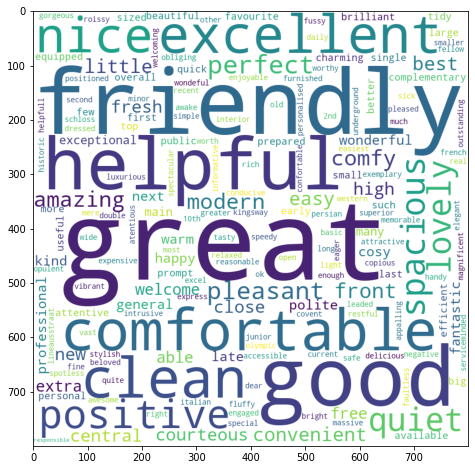

In [27]:
# word cloud for solo traveler
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(solo_features)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

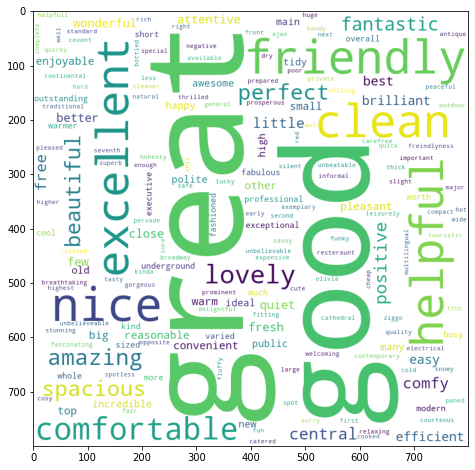

In [28]:
# word cloud for couple traveler
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(couple_features)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

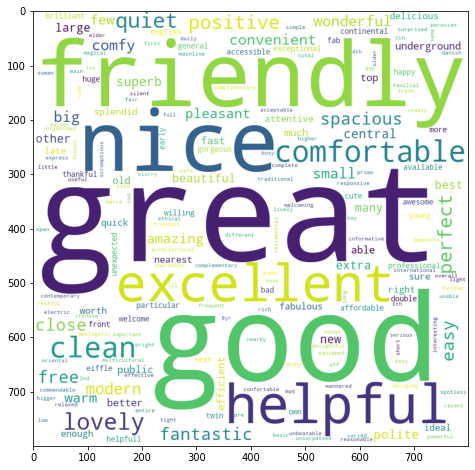

In [29]:
# word cloud for family traveler
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(family_features)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

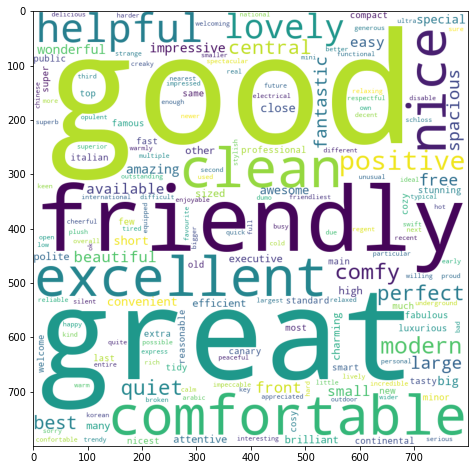

In [30]:
# word cloud for business traveler
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(business_features)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

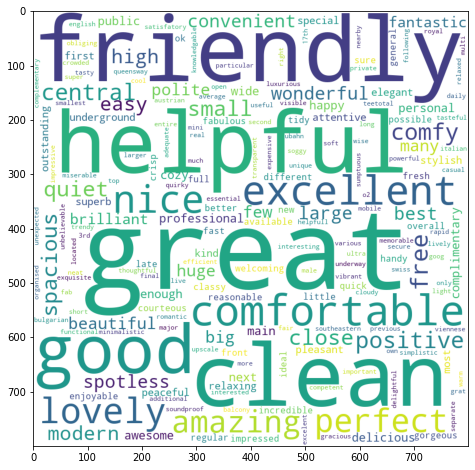

In [31]:
# word cloud for leisure traveler
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(leisure_features)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

## 3) What are the top five features customers like most and top five features they complain about most about hotels in United Kingdom, France, Italy, and Spain? Country information is available inside Hotel_Address. (2 points)

In [38]:
# turn hotel_address column into lower case
df_pos_sample['hotel_address'] = df_pos['hotel_address'].str.lower()

df_neg_sample['hotel_address'] = df_neg['hotel_address'].str.lower()

In [55]:
countries = {
    'united kingdom': {'positive': dict(), 'negative': dict()},
    'france': {'positive': dict(), 'negative': dict()},
    'italy': {'positive': dict(), 'negative': dict()},
    'spain': {'positive': dict(), 'negative': dict()},
}

In [56]:
for index, row in df_pos_sample.iterrows():
    address = row['hotel_address']
    if 'united kingdom' in address:
        positive = row['positive_comments']
        doc = nlp(positive)
        for token in doc:
            if token.pos_ == 'ADJ' or token.pos_ == 'NOUN':
                if token.text in countries['united kingdom']['positive']:
                    countries['united kingdom']['positive'][token.text] += 1
                else:
                    countries['united kingdom']['positive'][token.text] = 1

    elif 'france' in address:
        positive = row['positive_comments']
        doc = nlp(positive)
        for token in doc:
            if token.pos_ == 'ADJ' or token.pos_ == 'NOUN':
                if token.text in countries['france']['positive']:
                    countries['france']['positive'][token.text] += 1
                else:
                    countries['france']['positive'][token.text] = 1

    elif 'italy' in address:
        positive = row['positive_comments']
        doc = nlp(positive)
        for token in doc:
            if token.pos_ == 'ADJ' or token.pos_ == 'NOUN':
                if token.text in countries['italy']['positive']:
                    countries['italy']['positive'][token.text] += 1
                else:
                    countries['italy']['positive'][token.text] = 1

    elif 'spain' in address:
        positive = row['positive_comments']
        doc = nlp(positive)
        for token in doc:
            if token.pos_ == 'ADJ' or token.pos_ == 'NOUN':
                if token.text in countries['spain']['positive']:
                    countries['spain']['positive'][token.text] += 1
                else:
                    countries['spain']['positive'][token.text] = 1
    
countries

{'united kingdom': {'positive': {'staff': 535,
   'accommodation': 9,
   'complimentary': 12,
   'upgrade': 10,
   'husband': 4,
   'birthday': 23,
   'wonderful': 21,
   'location': 499,
   'hotel': 312,
   'bar': 53,
   'friendly': 249,
   'approachable': 3,
   'problem': 2,
   'great': 268,
   'fantastic': 57,
   'stay': 45,
   'comfy': 64,
   'beds': 36,
   'big': 21,
   'singles': 1,
   'twin': 1,
   'room': 360,
   'good': 236,
   'shower': 41,
   'hot': 12,
   'cookie': 5,
   'check': 21,
   'nice': 137,
   'touch': 17,
   'positive': 65,
   'coffee': 27,
   'foyer': 2,
   'high': 10,
   'speed': 2,
   'internet': 1,
   'helpful': 185,
   'modern': 51,
   'clean': 173,
   'parking': 12,
   'day': 24,
   'large': 22,
   'towels': 7,
   'quiet': 50,
   'double': 6,
   'glazing': 2,
   'swimming': 8,
   'pool': 17,
   'aspect': 1,
   'comfortable': 190,
   'spacious': 34,
   'excellent': 185,
   'tea': 17,
   'facilities': 50,
   'option': 2,
   'body': 1,
   'full': 6,
   'squeeze

In [57]:
for index, row in df_neg_sample.iterrows():
    address = row['hotel_address']
    if 'united kingdom' in address:
        negative = row['negative_comments']
        doc = nlp(negative)
        for token in doc:
            if token.pos_ == 'ADJ' or token.pos_ == 'NOUN':
                if token.text in countries['united kingdom']['negative']:
                    countries['united kingdom']['negative'][token.text] += 1
                else:
                    countries['united kingdom']['negative'][token.text] = 1

    elif 'france' in address:
        negative = row['negative_comments']
        doc = nlp(negative)
        for token in doc:
            if token.pos_ == 'ADJ' or token.pos_ == 'NOUN':
                if token.text in countries['france']['negative']:
                    countries['france']['negative'][token.text] += 1
                else:
                    countries['france']['negative'][token.text] = 1

    elif 'italy' in address:
        negative = row['negative_comments']
        doc = nlp(negative)
        for token in doc:
            if token.pos_ == 'ADJ' or token.pos_ == 'NOUN':
                if token.text in countries['italy']['negative']:
                    countries['italy']['negative'][token.text] += 1
                else:
                    countries['italy']['negative'][token.text] = 1

    elif 'spain' in address:
        negative = row['negative_comments']
        doc = nlp(negative)
        for token in doc:
            if token.pos_ == 'ADJ' or token.pos_ == 'NOUN':
                if token.text in countries['spain']['negative']:
                    countries['spain']['negative'][token.text] += 1
                else:
                    countries['spain']['negative'][token.text] = 1

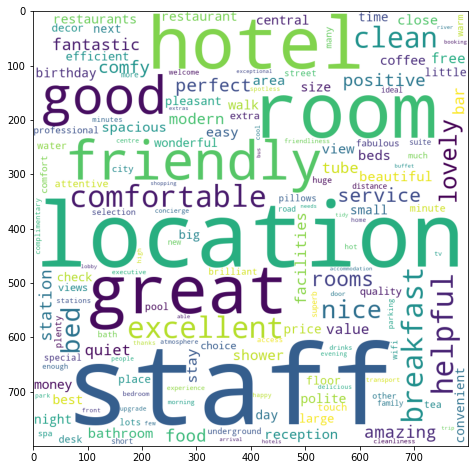

In [58]:
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(countries['united kingdom']['positive'])
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

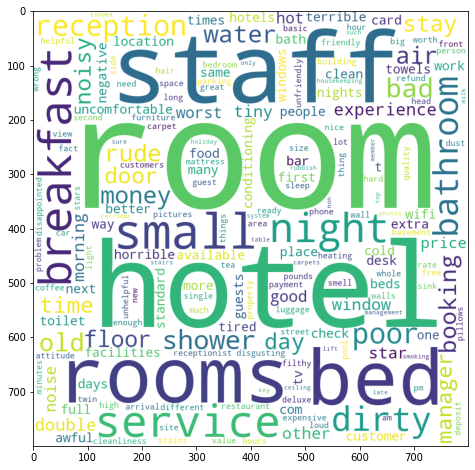

In [59]:
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(countries['united kingdom']['negative'])
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

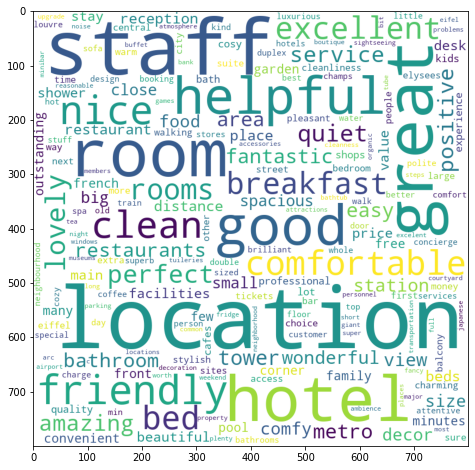

In [60]:
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(countries['france']['positive'])
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

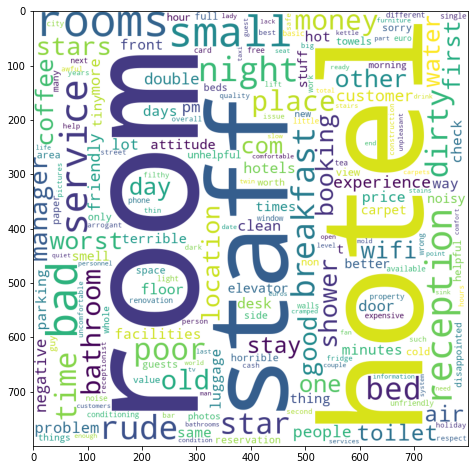

In [61]:
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(countries['france']['negative'])
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

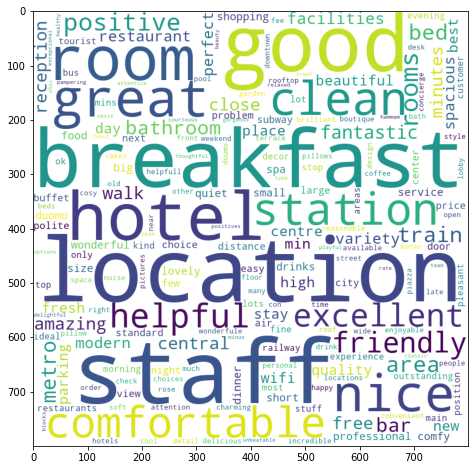

In [62]:
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(countries['italy']['positive'])
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

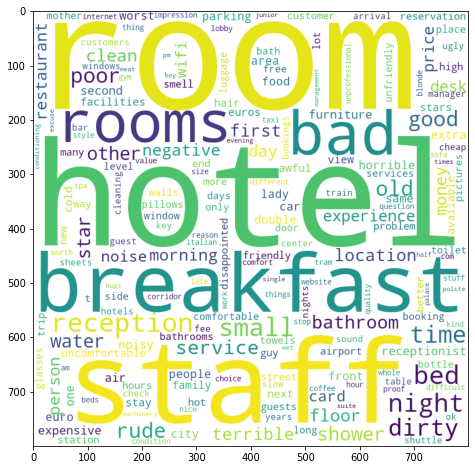

In [63]:
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(countries['italy']['negative'])
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

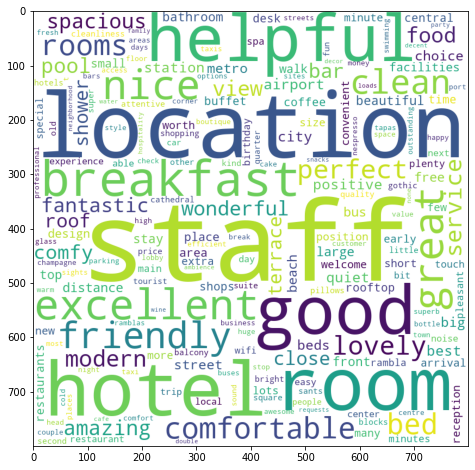

In [64]:
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(countries['spain']['positive'])
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

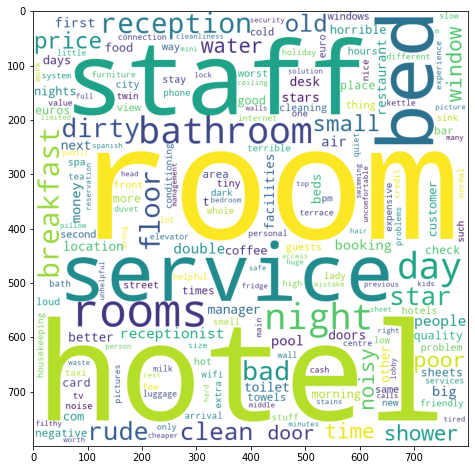

In [65]:
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(countries['spain']['negative'])
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

# 4) Create a dashboard with the following plots; (1) "Top Five Hotels Overall" with consistently high ratings, (2) Bottom Five Hotels Overall" with consistently low ratings, (3) Five Most Improved Hotels" with the highest improvement in average ratings from 2015 to 2017, showing their average ratings for each of the three years. (0.5+0.5+2 points).

In [88]:
# We will need this to store the hotels and the ratings
hotels = dict()

In [89]:
for index, row in df.iterrows():
    hotel_name = row['hotel_name']
    rating_year = row['review_date'].year
    rating = row['reviewer_score']
    if hotel_name not in hotels:
        hotels[hotel_name] = dict()
        hotels[hotel_name]['ratings'] = {rating_year: {'total': 1, 'rating': rating}}
        hotels[hotel_name]['overall_rating'] = [rating]
        hotels[hotel_name]['review_count'] = 1
    else:
        if rating_year not in hotels[hotel_name]['ratings']:
            hotels[hotel_name]['ratings'][rating_year] = {'total': 1, 'rating': rating}
        else:
            hotels[hotel_name]['ratings'][rating_year]['total'] += 1
            hotels[hotel_name]['ratings'][rating_year]['rating'] += rating
        hotels[hotel_name]['overall_rating'].append(rating)
        hotels[hotel_name]['review_count'] += 1

In [90]:
# for every hotel, we will calculate the average rating for each year
for hotel in hotels:
    for year in hotels[hotel]['ratings']:
        hotels[hotel]['ratings'][year]['rating'] /= hotels[hotel]['ratings'][year]['total']
        hotels[hotel]['ratings'][year]['total'] = 0

In [91]:
# for every hotel, calculate the difference between 2017 and 2015 rating
for hotel in hotels:
    # check if both years are present
    if 2015 in hotels[hotel]['ratings'] and 2017 in hotels[hotel]['ratings']:
        hotels[hotel]['growth'] = hotels[hotel]['ratings'][2017]['rating'] - hotels[hotel]['ratings'][2015]['rating']

In [92]:
# average rating for each hotel
for hotel in hotels:
    hotels[hotel]['overall_rating'] = sum(hotels[hotel]['overall_rating']) / len(hotels[hotel]['overall_rating'])

In [93]:
# remove hotels with less than 10 reviews
for hotel in list(hotels):
    if hotels[hotel]['review_count'] < 10:
        del hotels[hotel]

In [97]:
# top 5 hotels with highest rating
top_5_hotels = sorted(hotels, key=lambda x: hotels[x]['overall_rating'], reverse=True)[:5]
for hotel in top_5_hotels:
    print(hotel, hotels[hotel]['overall_rating'])

Ritz Paris 9.725
Hotel Casa Camper 9.7189368770764
41 9.711650485436897
H tel de La Tamise Esprit de France 9.688524590163938
Le Narcisse Blanc Spa 9.671929824561403


In [98]:
bottom_5_hotels = sorted(hotels, key=lambda x: hotels[x]['overall_rating'])[:5]
for hotel in bottom_5_hotels:
    print(hotel, hotels[hotel]['overall_rating'])

Hotel Liberty 5.121538461538464
Kube Hotel Ice Bar 5.852631578947369
Villa Eugenie 5.864516129032259
Savoy Hotel Amsterdam 6.009465020576125
Holiday Inn Paris Montparnasse Pasteur 6.3297297297297295


In [104]:
# new list only with hotels with growth
hotels_with_growth = dict()
for hotel in hotels:
    if 'growth' in hotels[hotel]:
        hotels_with_growth[hotel] = hotels[hotel]

# top 5 hotels with highest growth
top_5_hotels_growth = sorted(hotels_with_growth, key=lambda x: hotels_with_growth[x]['growth'], reverse=True)[:5]
for hotel in top_5_hotels_growth:
    print(hotel, hotels_with_growth[hotel]['growth'], f"2015 Average Rating: {hotels_with_growth[hotel]['ratings'][2015]['rating']}",
     f"2017 Average Rating: {hotels_with_growth[hotel]['ratings'][2017]['rating']}", '\n', sep="\n")

Le Lavoisier
7.5
2015 Average Rating: 2.5
2017 Average Rating: 10.0


Mercure Paris Bastille Saint Antoine
2.5666666666666664
2015 Average Rating: 5.0
2017 Average Rating: 7.566666666666666


L Edmond H tel
2.1227272727272757
2015 Average Rating: 6.45
2017 Average Rating: 8.572727272727276


MiHotel
1.9499999999999993
2015 Average Rating: 7.125
2017 Average Rating: 9.075


Villa Lut ce Port Royal
1.9255555555555555
2015 Average Rating: 5.594444444444445
2017 Average Rating: 7.5200000000000005


